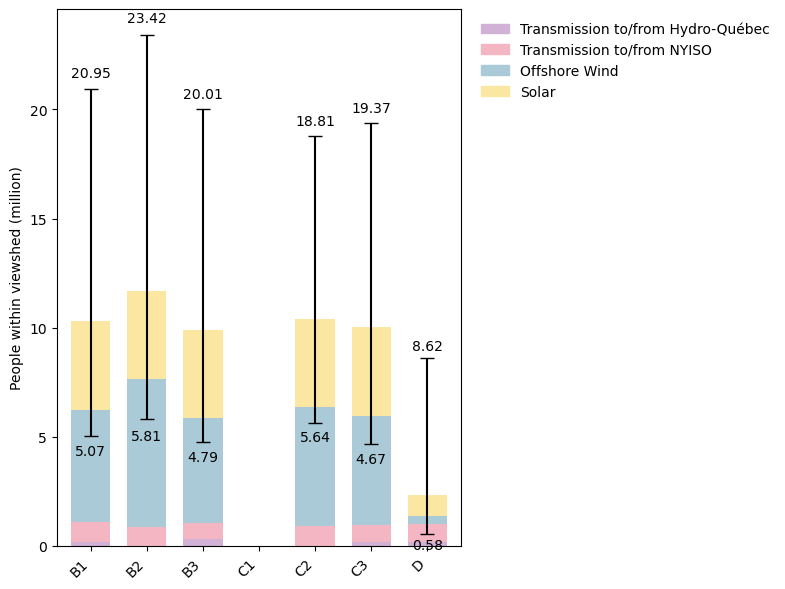

In [27]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
from shapely.geometry import Point
import matplotlib.pyplot as plt

# ── 0) USER PATHS ────────────────────────────────────────────────────────
xlsx       = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/1 Decarbonization Pathways/Decarbonization_Pathways.xlsx"
states_js  = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/4 External Data/U.S. Census Geo Data/US.json"
ls_dir     = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/4 External Data/ORNL LandScan/landscan-usa-2021-day"
conus_tif  = os.path.join(ls_dir, "landscan-usa-2021-conus-day.tif")

# ── 1) VIEWSHED BUFFERS (miles→m) & PROJECT SIZES ────────────────────────
buffers_m = {
    "Imports QC":    17 * 1609.34,
    "Imports NYISO": 17 * 1609.34,
    "Offshore Wind": 25 * 1609.34,
    "Solar":          3 * 1609.34,
}
proj_size = {
    "Imports QC":    1200,
    "Imports NYISO": 1200,
    "Offshore Wind": 1000,
    "Solar":          100,
}

# ── 2) MONTE CARLO SETTINGS ──────────────────────────────────────────────
n_mc = 100

# ── 3) BUILD ΔCAPACITY (cap_diff) ───────────────────────────────────────
sheets = pd.read_excel(xlsx, sheet_name=None)
df_list = []
for name, df in sheets.items():
    tmp = df.copy()
    tmp["Pathway"] = name
    df_list.append(tmp)
decarb = pd.concat(df_list, ignore_index=True)

# manual Canadian Hydro injection for B3
b3_map = {2025: 0, 2050: 3692.308}
decarb["Canadian Hydro"] = 0.0
mask = decarb["Pathway"] == "B3"
decarb.loc[mask, "Canadian Hydro"] = decarb.loc[mask, "Year"].map(b3_map).fillna(0)

techs_all = ["Solar","Onshore Wind","Offshore Wind",
             "Imports QC","Imports NYISO","Canadian Hydro","SMR","New NG"]
yr0 = decarb["Year"].min()
yr1 = decarb["Year"].max()
df0 = decarb.query("Year == @yr0").set_index("Pathway")
df1 = decarb.query("Year == @yr1").set_index("Pathway")
cap_diff_all = df1[techs_all] - df0[techs_all]

cap_diff = pd.DataFrame(index=cap_diff_all.index)
cap_diff["Imports QC"]    = cap_diff_all["Imports QC"]
cap_diff["Imports NYISO"] = cap_diff_all["Imports NYISO"]
cap_diff["Offshore Wind"] = cap_diff_all["Offshore Wind"]
cap_diff["Solar"]         = cap_diff_all["Solar"]
cap_diff = cap_diff.drop(index="A", errors="ignore")
pathways = cap_diff.index.tolist()

# ── 4) LOAD & PREPARE REGIONS ────────────────────────────────────────────
states = gpd.read_file(states_js).to_crs(epsg=5070)
ne = states[states["id"].isin(['09','23','25','33','44','50'])]
ne_poly = ne.unary_union
qc = states[states["id"].isin(['23','33','50'])].unary_union
nyiso = states[states["id"].isin(['09','25','50'])].unary_union
ow = states[states["id"].isin(['23','25','44'])]
region_offshore = ow.unary_union.buffer(buffers_m["Offshore Wind"]).difference(ne_poly)

# ── 5) OPEN LANDSCAN TILE ───────────────────────────────────────────────
src = rasterio.open(conus_tif)

# ── 6) MONTE CARLO EXPOSURE ──────────────────────────────────────────────
techs = ["Imports QC", "Imports NYISO", "Offshore Wind", "Solar"]
mc = np.zeros((n_mc, len(pathways), len(techs)))

for s in range(n_mc):
    for i, pw in enumerate(pathways):
        for j, tech in enumerate(techs):
            delta = cap_diff.at[pw, tech]
            pop_sum = 0.0
            if delta > 0:
                n_proj = int(np.ceil(delta / proj_size[tech]))
                if tech == "Imports QC":
                    region = qc
                elif tech == "Imports NYISO":
                    region = nyiso
                elif tech == "Offshore Wind":
                    region = region_offshore
                else:
                    region = ne_poly

                # sprinkle random points
                pts = []
                minx, miny, maxx, maxy = region.bounds
                while len(pts) < n_proj:
                    x = np.random.uniform(minx, maxx)
                    y = np.random.uniform(miny, maxy)
                    p = Point(x, y)
                    if region.contains(p):
                        pts.append(p)

                # buffer & mask
                for p in pts:
                    buf = p.buffer(buffers_m[tech])
                    geoms = gpd.GeoSeries([buf], crs=states.crs)\
                             .to_crs(src.crs).geometry
                    arr, _ = rasterio.mask.mask(src, geoms, crop=True, nodata=0)
                    pop_sum += arr.sum()

            mc[s, i, j] = pop_sum

mc /= 1e6  # convert to million people

# ── 7) COMPUTE MEAN & 95% CI ─────────────────────────────────────────────
mean_vals = mc.mean(axis=0)
low_vals  = np.percentile(mc, 2.5, axis=0)
high_vals = np.percentile(mc, 97.5, axis=0)

mean_df = pd.DataFrame(mean_vals, index=pathways, columns=techs)
low_df  = pd.DataFrame(low_vals,  index=pathways, columns=techs)
high_df = pd.DataFrame(high_vals, index=pathways, columns=techs)

mean_total   = mean_df.sum(axis=1)
err_low_arr  = mean_total.values - low_df.sum(axis=1).values
err_high_arr = high_df.sum(axis=1).values - mean_total.values

# ── 8) PLOT & ADD ERROR BARS (skip C1) ─────────────────────────────────
colors = {
    "Solar":         "#FBE7A1",
    "Onshore Wind":  "#B4D6E3",
    "Offshore Wind": "#A9CAD6",
    "Imports QC":    "#D1B1D6",
    "Imports NYISO": "#F4B6C2"
}
legend_mapping = {
    "Solar":        "Solar",
    "Onshore Wind": "Onshore Wind",
    "Offshore Wind":"Offshore Wind",
    "Imports QC":   "Transmission to/from Hydro-Québec",
    "Imports NYISO":"Transmission to/from NYISO"
}

ax = mean_df.plot(
    kind='bar',
    stacked=True,
    color=[colors[t] for t in techs],
    figsize=(8,6),
    width=0.7
)
ax.set_xticklabels(pathways, rotation=45, ha='right')
ax.set_ylabel("People within viewshed (million)")

# error bars for all except C1
mask_err = np.array(pathways) != "C1"
x = np.arange(len(pathways))
yerr = np.vstack([err_low_arr, err_high_arr])
ax.errorbar(
    x[mask_err],
    mean_total.values[mask_err],
    yerr=yerr[:, mask_err],
    fmt='none', ecolor='black', capsize=5
)

# annotate CI bounds (skip C1)
offset_arr = (err_low_arr + err_high_arr) * 0.025
for idx in np.where(mask_err)[0]:
    m  = mean_total.values[idx]
    lo = err_low_arr[idx]
    hi = err_high_arr[idx]
    off = offset_arr[idx]
    ax.text(idx, m + hi + off, f"{m+hi:.2f}", ha='center', va='bottom')
    ax.text(idx, m - lo - off, f"{m-lo:.2f}", ha='center', va='top')

# fixed legend call with handles
handles = [
    plt.matplotlib.patches.Patch(color=colors[t], label=legend_mapping[t])
    for t in techs
]
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.02,1),
          frameon=False)

plt.tight_layout()
plt.savefig('visual_impacts.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
plt.show()


In [28]:
mean_df

,Imports QC,Imports NYISO,Offshore Wind,Solar
B1,0.200353,0.905632,5.150128,4.040589
B2,0.000000,0.863018,6.806149,4.025943
B3,0.314044,0.731873,4.831344,4.030018
C1,0.000000,0.000000,0.000000,0.000000
C2,0.000000,0.917096,5.457900,4.044138
C3,0.200708,0.787178,4.956618,4.113459
D,0.178867,0.845793,0.367613,0.930464
